In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os


image_path = "/content/drive/MyDrive/FYP/lib_pic.jpeg"


if not os.path.exists(image_path):
    raise FileNotFoundError(f" Image not found at {image_path}. Check the filename and location!")


image = cv2.imread(image_path)
if image is None:
    raise ValueError(" Image could not be loaded. Ensure it's a valid image file.")


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


print(" Image loaded successfully!")


✅ Image loaded successfully!


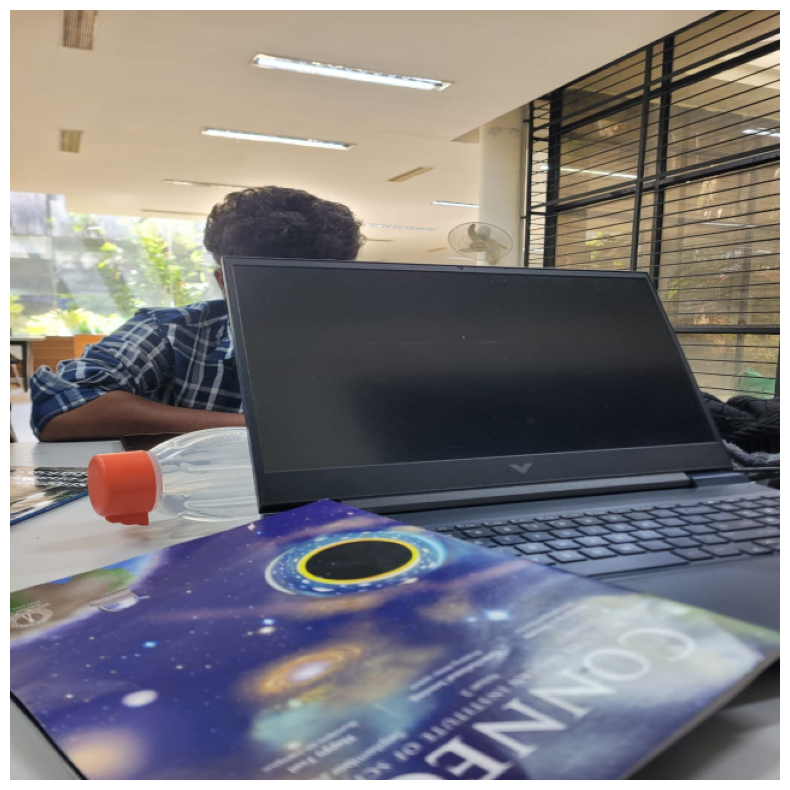

✅ Image transformed into tensor shape: torch.Size([1, 3, 640, 640])


In [ ]:
import matplotlib.pyplot as plt


input_size = (640, 640)
resized_image = cv2.resize(image, input_size)


plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
plt.axis("off")
plt.show()


import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

tensor_image = transform(resized_image).unsqueeze(0)
print(" Image transformed into tensor shape:", tensor_image.shape)


In [ ]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git
!pip install timm


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sntrim2m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sntrim2m
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done


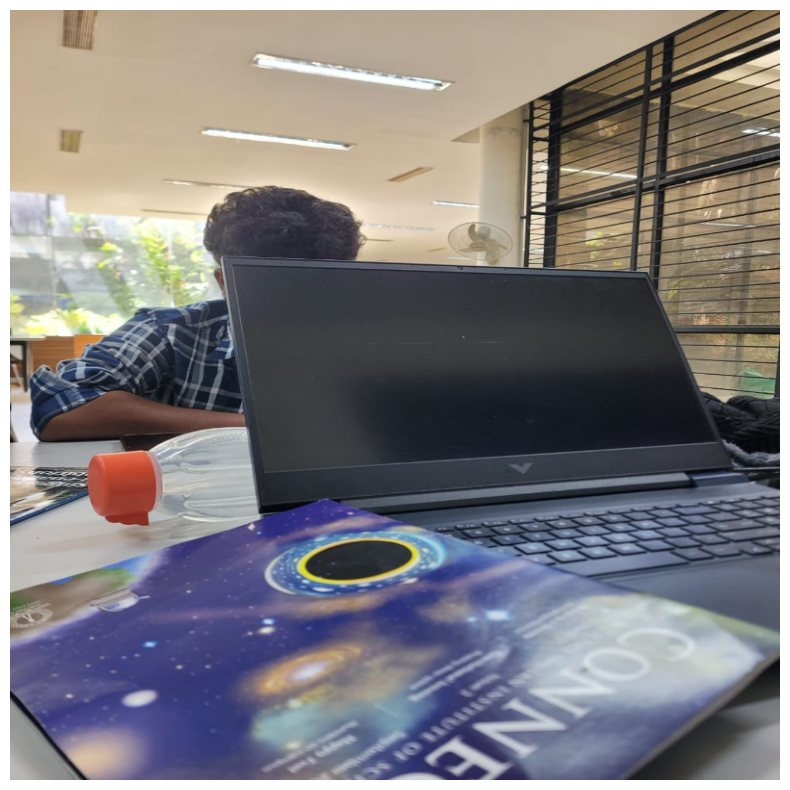

✅ Image transformed into tensor with shape: torch.Size([1, 3, 800, 800])


In [ ]:
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


input_size = (800, 800)
resized_image = cv2.resize(image, input_size)


plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
plt.axis("off")
plt.show()


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

tensor_image = transform(resized_image).unsqueeze(0)
print(f" Image transformed into tensor with shape: {tensor_image.shape}")


In [ ]:
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-2yy5e6qp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-2yy5e6qp
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import timm
import requests
from PIL import Image


rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
rcnn_model.eval()


detr_model = torch.hub.load("facebookresearch/detr:main", "detr_resnet50", pretrained=True)
detr_model.eval()


with torch.no_grad():
    rcnn_predictions = rcnn_model(tensor_image)
    detr_predictions = detr_model(tensor_image)

print(" Inference completed on both Faster-RCNN and DETR models.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


✅ Inference completed on both Faster-RCNN and DETR models.


In [ ]:
import matplotlib.patches as patches

def visualize_predictions(image, predictions, model_name, threshold=0.5, is_detr=False, class_names=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)

    if is_detr:

        pred_logits = predictions["pred_logits"].softmax(-1)[0, :, :-1]
        pred_boxes = predictions["pred_boxes"][0]
        pred_labels = pred_logits.argmax(-1)

        for i, (box, score, label) in enumerate(zip(pred_boxes, pred_logits.max(-1).values, pred_labels)):
            if score > threshold:
                x_center, y_center, width, height = box.cpu().numpy()
                x1 = (x_center - width / 2) * image.shape[1]
                y1 = (y_center - height / 2) * image.shape[0]
                x2 = (x_center + width / 2) * image.shape[1]
                y2 = (y_center + height / 2) * image.shape[0]

                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

                label_text = class_names[label] if class_names else f"Class {label}"
                ax.text(x1, y1, f"{model_name} | {label_text} | Score: {score:.2f}", color='white', fontsize=10, backgroundcolor="green")

    else:

        for pred in predictions:
            for i, score in enumerate(pred["scores"]):
                if score > threshold:
                    box = pred["boxes"][i].cpu().numpy()
                    label = pred["labels"][i].item()
                    x1, y1, x2, y2 = box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

                    label_text = class_names[label] if class_names else f"Class {label}"
                    ax.text(x1, y1, f"{model_name} | {label_text} | Score: {score:.2f}", color='white', fontsize=10, backgroundcolor="red")

    plt.show()


CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'utensil', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


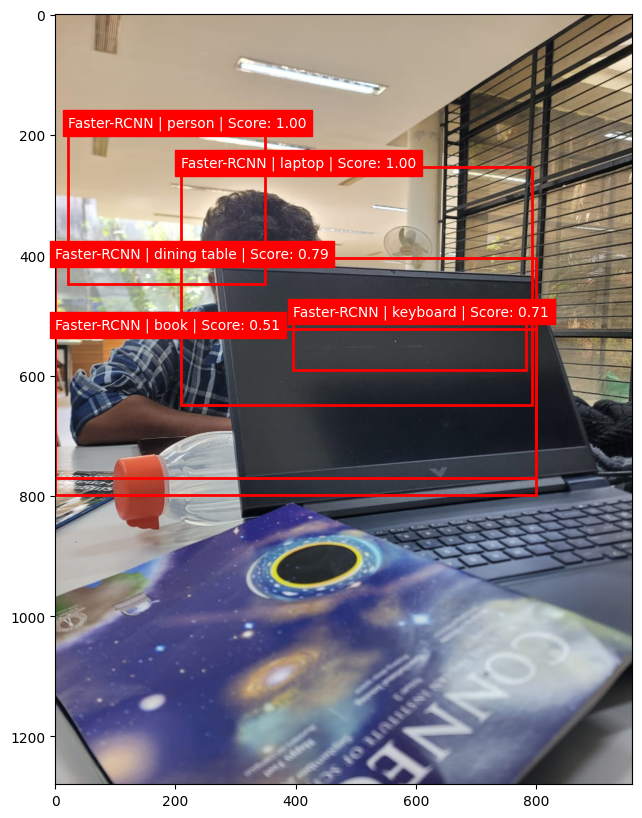

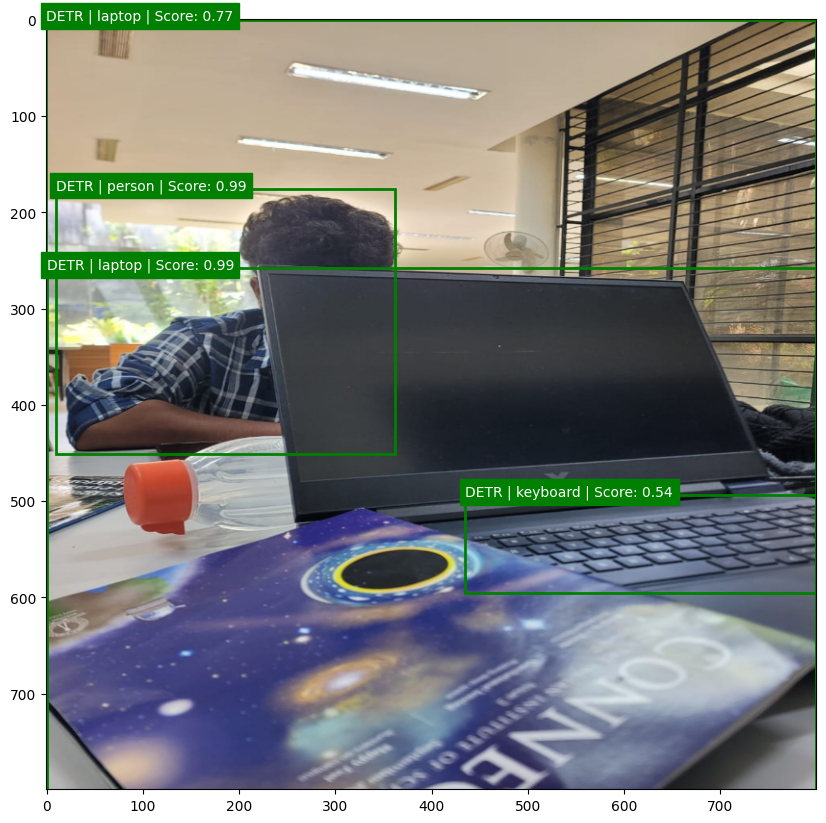

In [ ]:

visualize_predictions(image,  rcnn_predictions, "Faster-RCNN", class_names=CLASSES)



visualize_predictions(resized_image, detr_predictions, "DETR",class_names=CLASSES, threshold=0.3, is_detr=True)


In [ ]:
def visualize_combined_predictions(image, rcnn_preds, detr_preds, threshold=0.5, class_names=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)


    for pred in rcnn_preds:
        for i, score in enumerate(pred["scores"]):
            if score > threshold:
                box = pred["boxes"][i].cpu().numpy()
                label = pred["labels"][i].item()
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                label_text = class_names[label] if class_names else f"Class {label}"
                ax.text(x1, y1, f"Faster-RCNN | {label_text} | Score: {score:.2f}", color='white', fontsize=10, backgroundcolor="red")


    pred_logits = detr_preds["pred_logits"].softmax(-1)[0, :, :-1]
    pred_boxes = detr_preds["pred_boxes"][0]
    pred_labels = pred_logits.argmax(-1)

    for i, (box, score, label) in enumerate(zip(pred_boxes, pred_logits.max(-1).values, pred_labels)):
        if score > threshold:
            x_center, y_center, width, height = box.cpu().numpy()
            x1 = (x_center - width / 2) * image.shape[1]
            y1 = (y_center - height / 2) * image.shape[0]
            x2 = (x_center + width / 2) * image.shape[1]
            y2 = (y_center + height / 2) * image.shape[0]

            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

            label_text = class_names[label] if class_names else f"Class {label}"
            ax.text(x1, y1, f"DETR | {label_text} | Score: {score:.2f}", color='white', fontsize=10, backgroundcolor="green")

    plt.title("Hybrid Model: Faster-RCNN + DETR")
    plt.show()


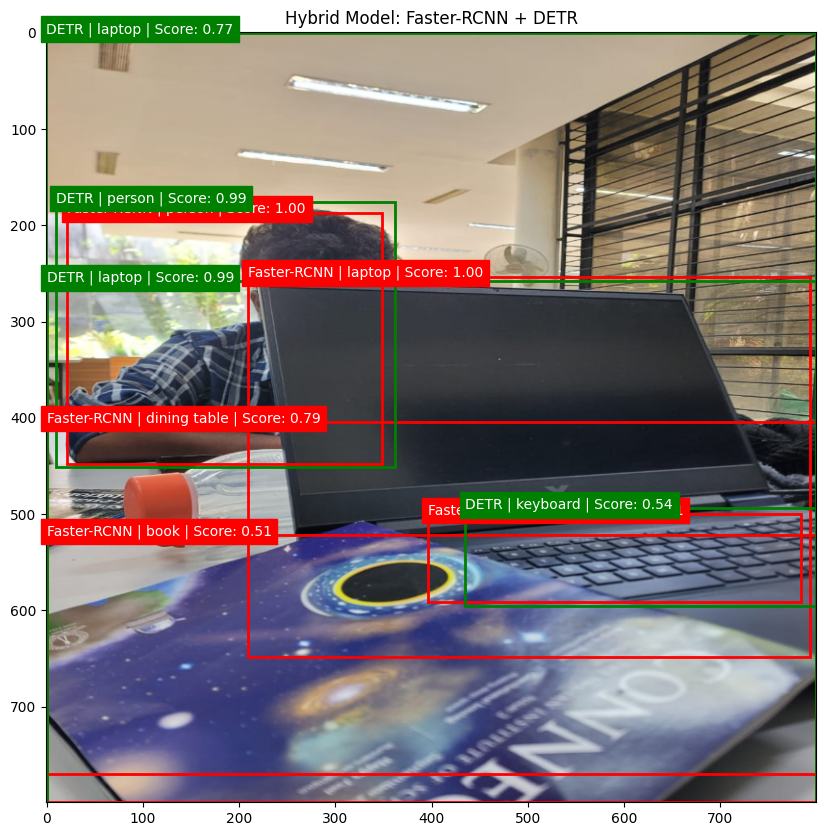

In [ ]:
visualize_combined_predictions(resized_image, rcnn_predictions, detr_predictions, class_names=CLASSES,threshold=0.5)
